In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
# Boundary condition 
coefii = 10

# X_0 = 0  #del
# Y_0 = 0     #w
X_0_v = -1/coefii
Y_0_v = 383.9911/coefii

In [4]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    return (X_prime+ws-Y)
    # return X_prime+ws-Y 

def F_E2(X_prime, X,Y_prime,Y, t):       # DE, works with numpy arrays
    # return Y_prime
    return Y_prime-K1+K2*np.sin(coefii*X)+K3*(-ws+Y)*coefii

In [5]:
# # Differential equation's exact solution - for comparison
# def X_t(t):
#     # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
#     return 0

# def Y_t(t):
#     return 0

In [6]:
t=np.random.uniform(0,3,size=100,requires_grad=False)

In [7]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [8]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [9]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [11]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     
M0 = 
[5.64872949]
M1 = 
[2.39356378]
M2 = 
[2.89889251]
M3 = 
[5.06592592]


In [12]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):

    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [13]:
# add the classical layer   #TODO
def classical_quantum_net_efficient(r1,w):
    return w[0]+w[1]*r1+w[2]*r1**2

In [14]:
def classical_quantum_net_prime(theta,w,t):



    r1=quantum_net(theta,t)[0]

    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [15]:
def classical_quantum_net_double_prime(theta,w,t):

   r1=quantum_net(theta,t)[0]
   r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 


   #Calculate double prime
   F_pos_pos_pi = quantum_net(theta,t+np.pi)[0]
   F_phi = quantum_net(theta,t)[0]
   F_phi_neg_pi = quantum_net(theta,t-np.pi)[0]
   r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)


   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [16]:
def classical_quantum_net_efficient(r1,w):
    return w[0]+w[1]*r1+w[2]*r1**2

In [17]:
def classical_quantum_net_prime_efficient(r1,r1_prime,w):
    return w[1]*r1_prime+2*w[2]*r1_prime*r1

In [18]:
def classical_quantum_net_double_prime_efficient(r1,r1_prime,r1_double_prime,w):
   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [19]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [20]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [21]:
# def cost(theta1,theta2,w1,w2,t):

#     # loss inner points
#     loss_i = 0

#     X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     Y_t_pred = X_t_pred+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     # loss_b = 0
#     # X_0_pred = classical_quantum_net(theta1,w1,0)
#     # Y_0_pred = classical_quantum_net(theta2,w2,0)

#     # # print(U_0)
#     # loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     # return 0.2*loss_b + 0.8*loss_i
#     return loss_i

In [22]:
def cost_efficient(theta1,w1,t):
    # loss inner points
    loss_i = 0
    # print('-------')
    r1 = np.array([quantum_net(theta1,t)[0] for t in t])

    # print(r1)

    r1_prime = np.array([qml.grad(quantum_net,argnum=1)(theta1,np.tensor(t)) for t in t])
    #Calculate double prime
    F_pos_pos_pi = np.array([quantum_net(theta1,t+np.pi)[0] for t in t])
    # print(len(F_pos_pos_pi))
    F_phi = r1
    F_phi_neg_pi = np.array([quantum_net(theta1,t-np.pi)[0] for t in t])
    r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)

    # print(r1)
    # print(r1_prime)
    # print(r1_double_prime)

    X_t_pred = classical_quantum_net_efficient(r1=theta1,w=w1)
    X_t_prime = classical_quantum_net_prime_efficient(r1=theta1,r1_prime=r1_prime,w=w1)
    
    Y_t_pred = X_t_prime+ws
    # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
    Y_t_prime = classical_quantum_net_double_prime_efficient(r1=theta1,r1_prime=r1_prime,r1_double_prime=r1_double_prime,w=w1)

    loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

    # # loss boundary points
    loss_b = 0
    X_0_pred = classical_quantum_net(theta1,w1,0)
    Y_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

    # # print(U_0)
    loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
    # return loss_b + loss_i
    return 0.2*loss_b + 0.8*loss_i

    return loss_i

In [23]:
# def cost(theta1,w1,t):

#     # loss inner points
#     loss_i = 0

#     X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     Y_t_pred = X_t_prime+ws
#     # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # # loss boundary points
#     loss_b = 0
#     X_0_pred = classical_quantum_net(theta1,w1,0)
#     Y_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

#     # # print(U_0)
#     loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     return loss_b + loss_i
#     # return 0.2*loss_b + 0.8*loss_i

#     return loss_i

In [24]:

# def cost(theta1,theta2,w1,w2,t):

#     # loss inner points
#     loss_i = 0

#     X_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
#     X_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
#     Y_t_pred = np.array([classical_quantum_net(theta=theta2,w=w2,t=point) for point in t])
#     Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])

#     loss_i += np.mean(F_E1(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)
#     loss_i += np.mean(F_E2(X=X_t_pred,Y=Y_t_pred,X_prime=X_t_prime,Y_prime=Y_t_prime,t=t)**2)

#     # loss boundary points
#     loss_b = 0
#     X_0_pred = classical_quantum_net(theta1,w1,0)
#     Y_0_pred = classical_quantum_net(theta2,w2,0)

#     # print(U_0)
#     loss_b += (X_0_v-X_0_pred)**2+(Y_0_v-Y_0_pred)**2
#     return 0.2*loss_b + 0.8*loss_i
#     # return loss_i

In [25]:
w1=np.zeros(3,requires_grad=True)
# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [26]:
start=now()
print(start)

2023-08-11 16:21:12.218287


In [27]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost_efficient,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 0.2999999999999988
Epoch: 2 | Cost: 0.6778910938792059
Epoch: 3 | Cost: 0.36190278723552405
Epoch: 4 | Cost: 0.282851136771953
Epoch: 5 | Cost: 0.18915739207836088
Epoch: 6 | Cost: 0.20335294746817317
Epoch: 7 | Cost: 0.30170830756811595
Epoch: 8 | Cost: 0.41191561715696773
Epoch: 9 | Cost: 0.5969562038568347
Epoch: 10 | Cost: 0.8993468008016253
Epoch: 11 | Cost: 0.3893289391737487
Epoch: 12 | Cost: 0.9753815262274104
Epoch: 13 | Cost: 1.3905749361176212
Epoch: 14 | Cost: 1.3176165025446427
Epoch: 15 | Cost: 0.8438310569203697
Epoch: 16 | Cost: 0.5758056517210246
Epoch: 17 | Cost: 0.4907829534849819
Epoch: 18 | Cost: 0.8522303481113573
Epoch: 19 | Cost: 0.5190398962333425
Epoch: 20 | Cost: 1.1857831019536218
Epoch: 21 | Cost: 0.5599999786398275
Epoch: 22 | Cost: 0.7884548848177438
Epoch: 23 | Cost: 0.906964227565567
Epoch: 24 | Cost: 0.7963241805439826
Epoch: 25 | Cost: 0.9766210763500965
Epoch: 26 | Cost: 0.5024803956965986
Epoch: 27 | Cost: 0.7466814564770596
Epoch: 

KeyboardInterrupt: 

In [28]:
# print(_cost)
t=np.random.uniform(0,1,size=50,requires_grad=False)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

[-0.25502571 -0.25281752 -0.25662847 -0.25172661 -0.25099387 -0.25132185
 -0.25818522 -0.25136936 -0.25101504 -0.25173347 -0.25102756 -0.25137768
 -0.25147373 -0.25117446 -0.25156005 -0.25094779 -0.25692738 -0.25295894
 -0.2511384  -0.25196609 -0.25661152 -0.25110517 -0.25119099 -0.25106215
 -0.25124492 -0.25126456 -0.2510455  -0.2509567  -0.25100055 -0.25711013
 -0.25374321 -0.25335414 -0.25117468 -0.25137593 -0.25104723 -0.25755745
 -0.25503764 -0.2510313  -0.25197615 -0.25588356 -0.25236522 -0.25235457
 -0.2561075  -0.25218639 -0.25540009 -0.25133529 -0.25449084 -0.2531848
 -0.2516067  -0.25369129]
[37.68182834 37.68754823 37.67877068 37.70456551 37.70086626 37.70322487
 37.67633433 37.69379434 37.69690012 37.70458239 37.70127846 37.70346284
 37.70382383 37.69522113 37.7041064  37.69997961 37.67826718 37.68709858
 37.69553832 37.69070583 37.67879979 37.70197841 37.69508314 37.7016211
 37.70285313 37.6945133  37.7014639  37.69795399 37.70095674 37.67796823
 37.68485516 37.6859205  37

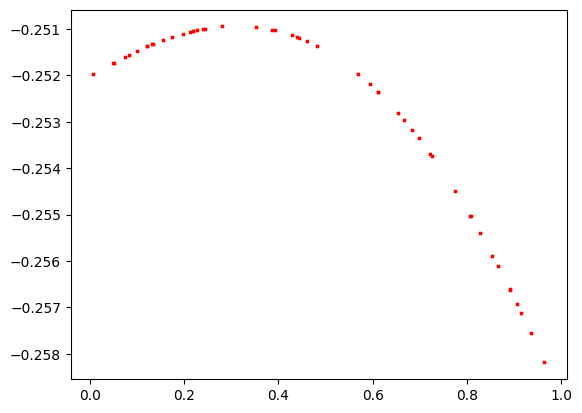

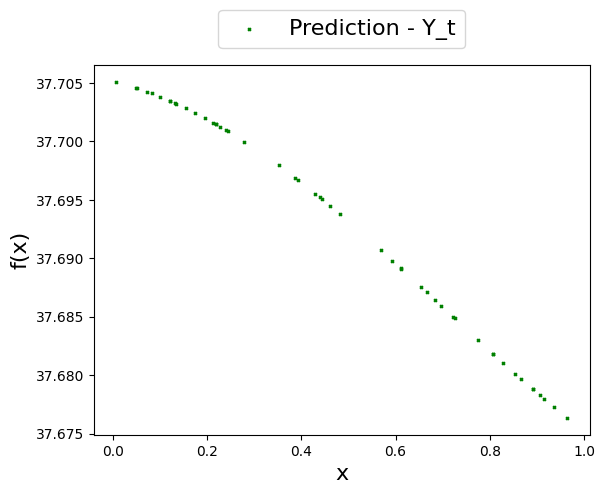

In [29]:
plt.figure()
# plt.scatter(t,X_t(t),facecolors='none', edgecolors='r', label='True - X_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - X_t')
# plt.scatter(t,Y_t(t),facecolors='none', edgecolors='g', label='True - Y_t')
plt.figure()
plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - Y_t')

plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()